In [1]:
import ROOT
import subprocess

In [2]:

whizard_prefix = subprocess.run(['whizard-config', '--prefix'], capture_output=True, encoding='ascii').stdout.strip()
whizard_libs = f"{whizard_prefix}/lib/"
print(whizard_libs)

/cvmfs/sw-nightlies.hsf.org/key4hep/releases/2025-05-20/x86_64-almalinux9-gcc14.2.0-opt/whizard/3.1.4-bkajy7/lib/


In [3]:
# ROOT.gInterpreter.Declare(f"R__ADD_LIBRARY_PATH({whizard_libs})")
# ROOT.gInterpreter.Declare("R__LOAD_LIBRARY(libomega_core.so.0)")
ROOT.gSystem.AddDynamicPath(whizard_libs)
ROOT.gSystem.Load("libomega_core.so")
ROOT.gSystem.Load("libwhizard.so")
ROOT.gSystem.Load("libwhizard_main.so")
ROOT.gSystem.Load("libomega.so")
ROOT.gSystem.Load("whizard/cc20_ac/.libs/default_lib.so")

0

In [4]:
ROOT.gInterpreter.Declare("#include \"test_whizard.h\"")

True

In [5]:
from model_parser import ModelParser
model_parser = ModelParser("SM_ac.mdl")
pars = model_parser.get_parameters_list()
print(pars)
ROOT.init_parameters(pars)

[1.16639e-05, 91.1882, 80.419, 125.0, 0.1178, 0.000511, 0.1057, 1.777, 0.12, 1.25, 4.2, 174.0, 1.523, 2.443, 2.049, 0.004143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 5000.0, 0.0, 0.0, 0.0, 0.0, 246.21845810181634, 0.8819013863635865, 0.4714339240338821, 0.30795615429614365, 0.0, 0.0, 0.0, 132.50494581248503]


In [6]:
%%cpp

std::array<double, 6*4> p1 = {
 1.2500000E+02, 0.0000000E+00, 0.0000000E+00, 1.2500000E+02,
 1.2500000E+02, 0.0000000E+00, 0.0000000E+00,-1.2500000E+02,
 1.0091697E+02, 1.9631897E+01,-4.3110336E+01, 8.9108485E+01,
 2.4400926E+01,-2.2812469E+01,-5.5731052E+00,-6.6284939E+00,
 4.9363948E+01, 2.4150784E+01,-1.1012284E+01,-4.1620531E+01,
 7.5318157E+01,-2.0970211E+01, 5.9695725E+01,-4.0859460E+01
};
OMEGA_FUN(new_event)(p1.data());


In [7]:
sqme1 = ROOT.sqme(1)
sqme2 = ROOT.sqme(2)
print(sqme1/4.007412298738E-03)
print(sqme2/4.007412298738E-03)
print((sqme1+sqme2)/4.007412298738E-03)

0.00436847029806741
0.9999980375273085
1.004366507825376


In [8]:
df = ROOT.RDataFrame("events", "whizard/cc20_ac/ww.100k.edm4hep.root")

In [9]:
df = df.Define("mc_lvec", "Construct<ROOT::Math::PxPyPzMVector>(MCParticle.momentum.x, MCParticle.momentum.y, MCParticle.momentum.z, MCParticle.mass)")

In [10]:
# for debugging:
df = df.Define("W_lvec", "mc_lvec[2] + mc_lvec[3]")
df = df.Define("cosTheta", "cos(W_lvec.theta())")

In [11]:
df = df.Define("E", "return Map(mc_lvec, [] (const auto& el) {return el.energy();})")

In [12]:

df = df.Define("PX", "MCParticle.momentum.x")
df = df.Define("PY", "MCParticle.momentum.y")
df = df.Define("PZ", "MCParticle.momentum.z")


In [13]:

df = df.Define("momenta", """
               std::array<double, 6*4>({
               E[0], PX[0], PY[0], PZ[0],
               E[1], PX[1], PY[1], PZ[1],
               E[2], PX[2], PY[2], PZ[2],
               E[3], PX[3], PY[3], PZ[3],
               E[4], PX[4], PY[4], PZ[4],
               E[5], PX[5], PY[5], PZ[5],
               })
               """)
# FIXME: does the calculation twice :(
df = df.Define("sqme1", "sqme(momenta.data(), 1)")
df = df.Define("sqme2", "sqme(momenta.data(), 2)")

In [ ]:
ROOT.gInterpreter.Declare("#include <podio/GenericParameters.h>")
df = df.Define("Parameters", "podio::GenericParameters par; par.loadFrom(GPDoubleKeys, GPDoubleValues); par.loadFrom(GPFloatKeys, GPFloatValues); par.loadFrom(GPIntKeys, GPIntValues); par.loadFrom(GPStringKeys, GPStringValues); return par;")
df = df.Define("sqme_whizard", "Parameters.get<double>(\"sqme\").value_or(-42.0)")
df = df.Define("sqme_alt1_whizard", "Parameters.get<double>(\"sqme_alt1\").value_or(-42.0)")
df = df.Define("e_charge", "MCParticle.charge[2]")

In [15]:
df = df.Define("recalc_weight", "(e_charge > 0 ? sqme1 : sqme2) / sqme_whizard")
df = df.Define("recalc_weight2", "(sqme1 + sqme2) / sqme_whizard")

In [16]:
# for debugging:
df = df.Define("inv_sqme_whizard", "1.0 / sqme_whizard")
df = df.Define("inv_sqme1", "1.0 / sqme1")
df = df.Define("inv_sqme2", "1.0 / sqme2")
df = df.Define("inv_sqme_correct", "1.0 / (e_charge > 0 ? sqme1 : sqme2)")
n_bins = 5
h_cw_w = df.Histo1D(("", "; cos #theta", 5, -1., 1.), "cosTheta", "inv_sqme_whizard")
h_cw_1 = df.Histo1D(("", "; cos #theta", 5, -1., 1.), "cosTheta", "inv_sqme1")
h_cw_2 = df.Histo1D(("", "; cos #theta", 5, -1., 1.), "cosTheta", "inv_sqme2")
h_cw_c = df.Histo1D(("", "; cos #theta", 5, -1., 1.), "cosTheta", "inv_sqme_correct")

In [17]:
h = df.Histo1D("recalc_weight2")

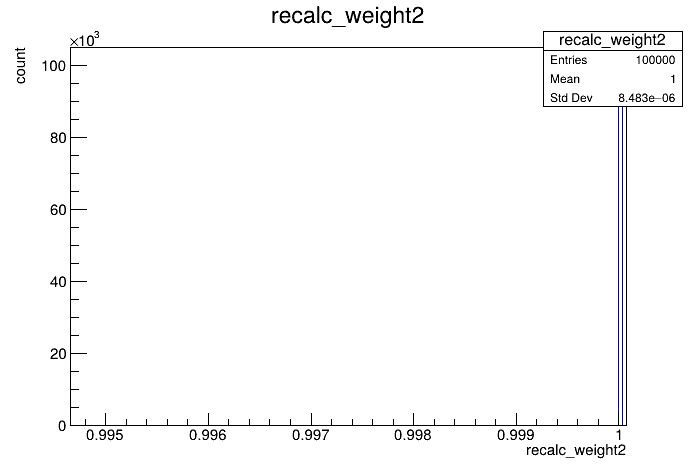

In [18]:
c = ROOT.TCanvas()
h.Draw()
c.Draw()

In [19]:
df.Filter("recalc_weight < 0.99").Display(["sqme_whizard", "sqme1", "sqme2", "recalc_weight", "e_charge"]).Print()

+-----+--------------+----------+----------+---------------+-----------+
| Row | sqme_whizard | sqme1    | sqme2    | recalc_weight | e_charge  | 
+-----+--------------+----------+----------+---------------+-----------+
| 0   | 0.001320     | 0.000094 | 0.001226 | 0.928487      | -1.000000 | 
+-----+--------------+----------+----------+---------------+-----------+
| 6   | 0.000300     | 0.000026 | 0.000273 | 0.912351      | -1.000000 | 
+-----+--------------+----------+----------+---------------+-----------+
| 7   | 0.000126     | 0.000123 | 0.000003 | 0.979532      | 1.000000  | 
+-----+--------------+----------+----------+---------------+-----------+
| 8   | 0.000442     | 0.000005 | 0.000437 | 0.988424      | -1.000000 | 
+-----+--------------+----------+----------+---------------+-----------+
| 12  | 0.000006     | 0.000000 | 0.000005 | 0.051301      | 1.000000  | 
+-----+--------------+----------+----------+---------------+-----------+


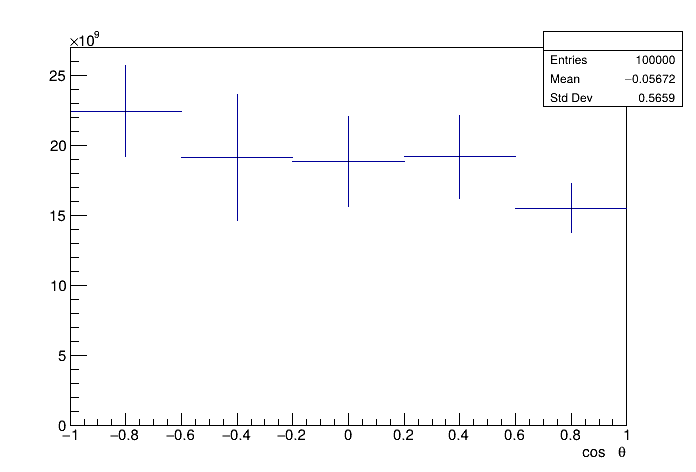

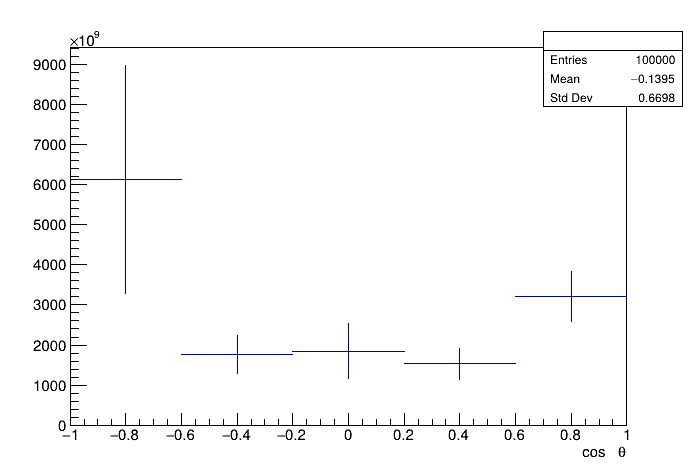

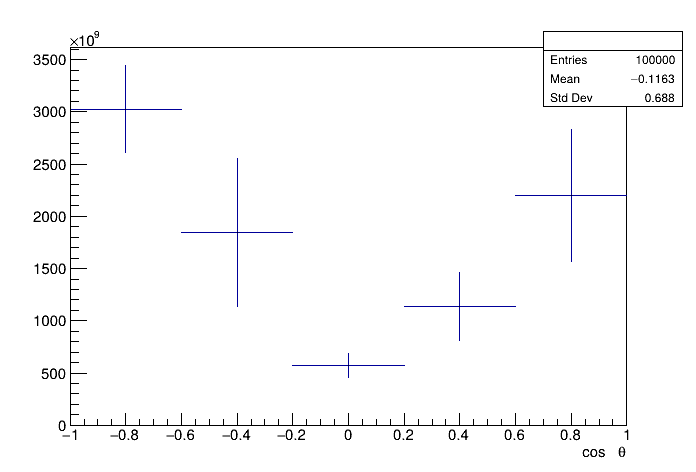

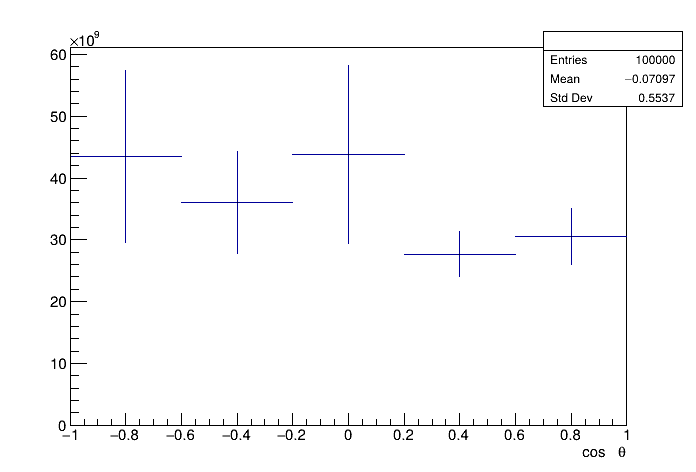

In [20]:
c_cw_w = ROOT.TCanvas()
h_cw_w.Draw()
h_cw_w.SetMinimum(0)
c_cw_w.Draw()

c_cw_1 = ROOT.TCanvas()
h_cw_1.Draw()
h_cw_1.SetMinimum(0)
c_cw_1.Draw()

c_cw_2 = ROOT.TCanvas()
h_cw_2.Draw()
h_cw_2.SetMinimum(0)
c_cw_2.Draw()

c_cw_c = ROOT.TCanvas()
h_cw_c.Draw()
h_cw_c.SetMinimum(0)
c_cw_c.Draw()